# Dynex SDK - TEST SDK 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dynex
import dimod
from pyqubo import Array

## Verify Version of Dynex SDK

In [3]:
dynex.__version__

'0.1.7'

## Test your configuration

Successful run is required to start sampling with the Dynex SDK

In [4]:
dynex.test()

[DYNEX] TEST: dimod BQM construction...
[DYNEX] PASSED
[DYNEX] TEST: Dynex Sampler object...
[DYNEX] PASSED
[DYNEX] TEST: uploading computing file...


file upload progress:   0%|          | 0.00/45.0 [00:00<?, ?B/s]

[DYNEX] PASSED
[DYNEX] TEST: submitting sample file...


file upload progress:   0%|          | 0.00/45.0 [00:00<?, ?B/s]

[DYNEX] PASSED
[DYNEX] TEST: retrieving samples...
[DYNEX] PASSED
[DYNEX] TEST: worker access to computing files
[DYNEX] PASSED
[DYNEX] TEST RESULT: ALL TESTS PASSED


## View your API acccount

In [5]:
dynex.account_status()

ACCOUNT: Dynex Devs
API SUCCESSFULLY CONNECTED TO DYNEX
-----------------------------------
ACCOUNT LIMITS:
MAXIMUM NUM_READS: 100,000,000
MAXIMUM ANNEALING_TIME: 10,000
MAXIMUM JOB DURATION: 60 MINUTES

USAGE:
TOTAL USAGE: 180,093,507,360 / 10,000,000,000,000 ( 1.8009350736 %) NUM_READS x ANNEALING_TIME


## Create a simple QUBO formulation

In [6]:
N = 15
K = 3
numbers = [4.8097315016016315, 4.325157567810298, 2.9877429101815127,
           3.199880179616316, 0.5787939511978596, 1.2520928214246918,
           2.262867466401502, 1.2300003067401255, 2.1601079352817925,
           3.63753899583021, 4.598232793833491, 2.6215815162575646,
           3.4227134835783364, 0.28254151584552023, 4.2548151473817075]

q = Array.create('q', N, 'BINARY')
H = sum(numbers[i] * q[i] for i in range(N)) + 5.0 * (sum(q) - K)**2
model = H.compile()
Q, offset = model.to_qubo(index_label=True)

In [7]:
# BQM from QUBO:
bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset)

## Sample on Dynex

In [8]:
model = dynex.BQM(bqm);
sampler = dynex.DynexSampler(model,  mainnet=True, description='Dynex SDK test');
sampleset = sampler.sample(num_reads=5000, annealing_time = 200, debugging=False);
print('Result:')
print(sampleset)

╭────────────┬───────────┬───────────┬─────────┬──────┬─────────┬───────┬─────┬──────────┬───────────╮
│   DYNEXJOB │   ELAPSED │   WORKERS │   CHIPS │    ✔ │   STEPS │   LOC │   ✔ │   ENERGY │         ✔ │
├────────────┼───────────┼───────────┼─────────┼──────┼─────────┼───────┼─────┼──────────┼───────────┤
│       6345 │      0.26 │         1 │       0 │ 4992 │     200 │     0 │  14 │        0 │ 290466.00 │
╰────────────┴───────────┴───────────┴─────────┴──────┴─────────┴───────┴─────┴──────────┴───────────╯
╭───────────────────────────────────┬───────────┬─────────┬───────┬──────────┬───────────┬───────────────┬──────────╮
│                            WORKER │   VERSION │   CHIPS │   LOC │   ENERGY │   RUNTIME │   LAST UPDATE │   STATUS │
├───────────────────────────────────┼───────────┼─────────┼───────┼──────────┼───────────┼───────────────┼──────────┤
│       *** WAITING FOR WORKERS *** │           │         │       │          │           │               │          │
│ Boost job p

## Sample on Dynex using clones

In [9]:
model = dynex.BQM(bqm);
sampler = dynex.DynexSampler(model,  mainnet=True, description='Dynex SDK test');
sampleset = sampler.sample(num_reads=20000, annealing_time = 1000, clones = 4, debugging=False);
print('Result:')
print(sampleset)

[DYNEX] MODEL CONVERTED TO QUBO
[DYNEX] PRECISION SET TO 0.001
[DYNEX] QUBO: Constant offset of the binary quadratic model: 45.0
[DYNEX] STARTING SAMPLING ( 4 CLONES )...
[DYNEX] Clone 0 started...
[DYNEX] Clone 1 started...
[DYNEX] Clone 3 started...
[DYNEX] Clone 2 started...


file upload progress:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

file upload progress:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

file upload progress:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

file upload progress:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

[DYNEX] Clone 0 finished
[DYNEX] Clone 1 finished
[DYNEX] Clone 3 finished
[DYNEX] Clone 2 finished
Result:
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14    energy num_oc.
2  0  1  0  0  0  0  0  1  0  0  1  0  0  0  0  2.091336       2
0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  6.808794       1
1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0 20.282542       2
['BINARY', 3 rows, 5 samples, 15 variables]


## Draw Sampleset

In [10]:
import matplotlib.pyplot as plt
import numpy as np

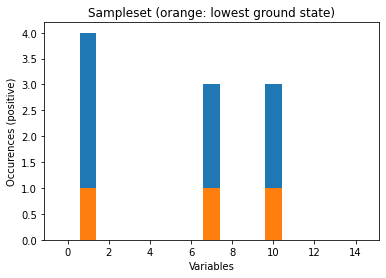

In [11]:
# generate data:
data = np.zeros(len(sampleset.variables)) 
for s in sampleset.record: #s[0] samples [1] energy [2] num_oc
    for i in range(0,len(s[0])):
        data[i] += ( s[0][i] * s[2] ); # weighted by num_oc

plt.bar(sampleset.variables, data)
plt.bar(sampleset.variables, sampleset.first.sample.values())
plt.xlabel("Variables")
plt.ylabel("Occurences (positive)")
plt.title("Sampleset (orange: lowest ground state)")
plt.show() 

## Multi model parallel sampling

In [54]:
model = dynex.BQM(bqm);

models = [];
models.append(model);
models.append(model);

sampler = dynex.DynexSampler(model,  mainnet=True, description='Dynex SDK test');

[DYNEX] MODEL CONVERTED TO QUBO
[DYNEX] PRECISION SET TO 0.001
[DYNEX] QUBO: Constant offset of the binary quadratic model: 45.0


In [56]:
sampleset = sampler.sample(num_reads=5000, annealing_time = 200, debugging=False);
print('Result:')
print(sampleset)

╭────────────┬───────────┬───────────┬─────────┬──────┬─────────┬───────┬─────┬──────────┬───────────╮
│   DYNEXJOB │   ELAPSED │   WORKERS │   CHIPS │    ✔ │   STEPS │   LOC │   ✔ │   ENERGY │         ✔ │
├────────────┼───────────┼───────────┼─────────┼──────┼─────────┼───────┼─────┼──────────┼───────────┤
│       6353 │      0.25 │         1 │       0 │ 4992 │     200 │     0 │  12 │        0 │ 290466.00 │
╰────────────┴───────────┴───────────┴─────────┴──────┴─────────┴───────┴─────┴──────────┴───────────╯
╭───────────────────────────────────┬───────────┬─────────┬───────┬──────────┬───────────┬───────────────┬──────────╮
│                            WORKER │   VERSION │   CHIPS │   LOC │   ENERGY │   RUNTIME │   LAST UPDATE │   STATUS │
├───────────────────────────────────┼───────────┼─────────┼───────┼──────────┼───────────┼───────────────┼──────────┤
│       *** WAITING FOR WORKERS *** │           │         │       │          │           │               │          │
│ Boost job p